# Compresión de imágenes RGB

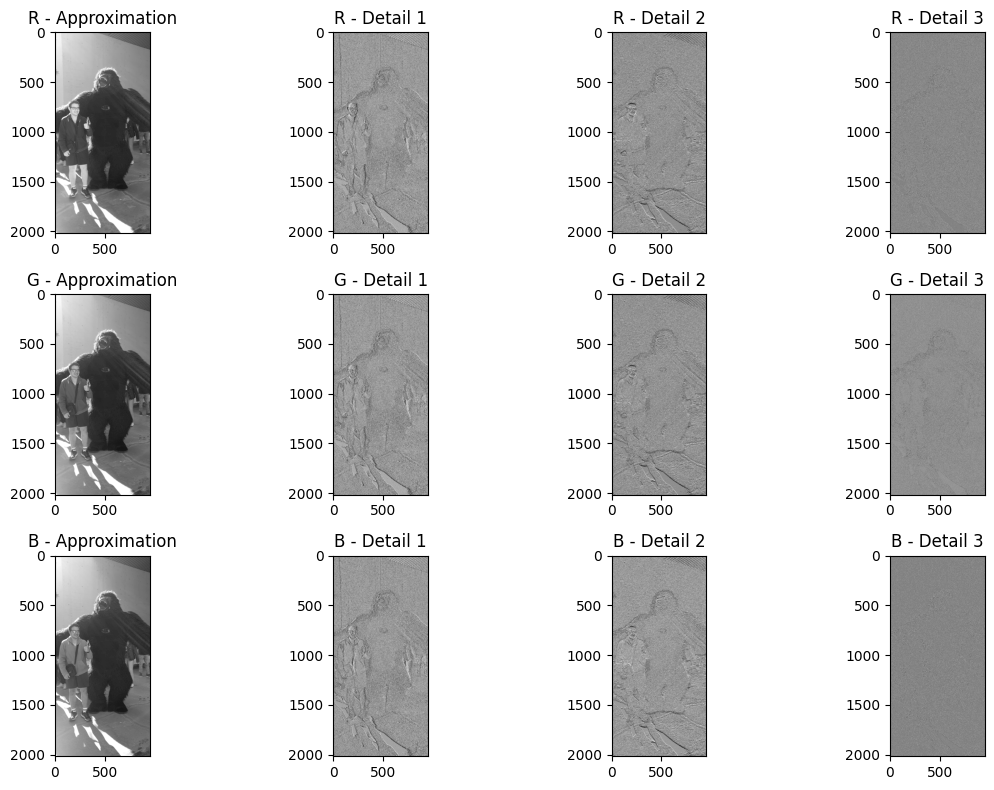

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


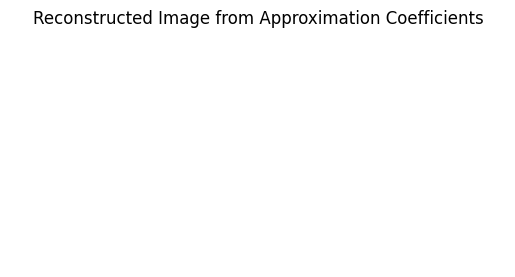

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image
from skimage import exposure

# Load an RGB image
image_path = './data/harambe.jpg'  # Replace with your image path
img = Image.open(image_path)
img_array = np.array(img)

# Split the image into RGB channels
r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

# Perform wavelet transform on each channel separately
def apply_wavelet(channel):
    coeffs = pywt.dwt2(channel, 'haar')  # Using Haar wavelet, you can change this
    cA, (cH, cV, cD) = coeffs  # Approximation, Horizontal, Vertical, Diagonal details
    return cA, cH, cV, cD

# Apply wavelet transform to each channel

r_coeffs = apply_wavelet(r)
g_coeffs = apply_wavelet(g)
b_coeffs = apply_wavelet(b)

# Displaying the results for R, G, and B channels after wavelet transform using axs
fig, axs = plt.subplots(3, 4, figsize = (12, 8))

# Plotting RGB channels after wavelet transform (including rotation and flipping)
for i, coeffs in enumerate([r_coeffs, g_coeffs, b_coeffs]):
    # Display the approximation coefficients
    axs[i, 0].imshow(np.fliplr(np.transpose(coeffs[0])), cmap='gray')  # Flip vertically after transpose
    axs[i, 0].set_title(f'{["R", "G", "B"][i]} - Approximation')

    # Display the detail coefficients with enhanced contrast
    for j, coeff in enumerate(coeffs[1:]):
        equalized_coeff = exposure.equalize_hist(coeff)
        equalized_coeff_rotated = np.fliplr(np.transpose(equalized_coeff))  # Flip vertically after transpose
        
        axs[i, j+1].imshow(equalized_coeff_rotated, cmap='gray')
        axs[i, j+1].set_title(f'{["R", "G", "B"][i]} - Detail {j+1}')

plt.tight_layout()
plt.show()

# Initialize arrays to store reconstructed R, G, B channels
reconstructed_r = pywt.idwt2((r_coeffs[0], (None, None, None,)), 'haar')  # Use only the approximation
reconstructed_g = pywt.idwt2((g_coeffs[0], (None, None, None,)), 'haar')
reconstructed_b = pywt.idwt2((b_coeffs[0], (None, None, None,)), 'haar')

# Stack the channels to form the reconstructed RGB image
reconstructed_image = np.stack((reconstructed_r, reconstructed_g, reconstructed_b), axis =-1)
print("hola")
# Display the reconstructed image
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image from Approximation Coefficients')
plt.axis('off')
plt.show()
